In [87]:
# Imports
import numpy as np
from sklearn.metrics import silhouette_score
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
import cv2
from validclust import dunn
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import matplotlib.cm as cm

In [88]:
# Loading the Cifar dataset.
(train_X, train_Y), (test_X, test_Y) = cifar10.load_data()

In [89]:
# Preprocessing (Converting the images to grayscale)
test_X_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_X])
train_X_gray = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in train_X])

In [90]:
# Normalizing the images
test_images_base = test_X_gray.astype('float32') / 255
train_images = train_X_gray.astype('float32') / 255

In [91]:
# Shape of train and test images.
print('Test Images Shape:', test_images_base.shape)
print('Train Images Shape:', train_images.shape)

Test Images Shape: (10000, 32, 32)
Train Images Shape: (50000, 32, 32)


In [92]:
# Reshaping the images
test_images = test_images_base.reshape((len(test_images_base), 1024))
train_images = train_images.reshape((len(train_images), 32, 32, 1))

In [93]:
# Shape of train and test images.
print('Test Images Shape:', test_images.shape)
print('Train Images Shape:', train_images.shape)

Test Images Shape: (10000, 1024)
Train Images Shape: (50000, 32, 32, 1)


In [94]:
k = 10
c_init=[]
random_image_indexes=[np.random.randint(len(test_images)) for i in range(k)]
for i in random_image_indexes:
    c_init.append(test_images[i])

In [95]:
# Decide which image is assigned to which cluster
def create_cluster(test_images,k,centroids):
    clusters = []
    for image in test_images:
        euclidean = []
        for i in range(k):
            euclidean.append(np.linalg.norm(image - centroids[i]))
        clusters.append(np.argmin(euclidean))
    return np.asarray(clusters)

In [98]:
def update_centroid(test_images,k,clusters):
    centroids = []
    for i in range(k):
        images=[]
        for j in range(len(test_images)):
            if clusters[j]==i:
                images.append(test_images[j])
        centroids.append(np.mean(images,axis=0))
    return np.asarray(centroids)

In [99]:
#Find the change between the previous centroid and the updated centroid
def change(init,new):
    change=0
    for i in range(len(init)):
        change+=np.linalg.norm(init[i]-new[i])
    return change

In [100]:
cent_change = 500

while cent_change>0.001:
    clusters = create_cluster(test_images,k,c_init)
    c_new = update_centroid(test_images,k,clusters)
    cent_change = change(c_init,c_new)
    print(cent_change)
    c_init=c_new

43.9468789100647
11.907719075679779
7.527269810438156
5.543906152248383
4.388540834188461
3.0718835592269897
2.057525783777237
1.657406471669674
1.36373919993639
1.0823787301778793
0.942449264228344
0.7474946603178978
0.7060101665556431
0.708784893155098
0.5835828790441155
0.5489950887858868
0.4423555303364992
0.4033790472894907
0.4381731553003192
0.4020070545375347
0.3079705345444381
0.24988159257918596
0.3067398313432932
0.2837896989658475
0.26520070619881153
0.22837310656905174
0.24967563897371292
0.21142596192657948
0.17483424907550216
0.14246970834210515
0.07897201366722584
0.10140755493193865
0.09094317653216422
0.07981016300618649
0.08553513349033892
0.079496412537992
0.08544517168775201
0.04268944216892123
0.031919757835567
0.051092046312987804
0.02479037968441844
0.010812265798449516
0.0


In [101]:
silhouette_avg = silhouette_score(test_images, clusters)
print("The average silhouette score is :", silhouette_avg)

The average silhouette score is : 0.058239162


In [102]:
dunn(pairwise_distances(test_images), clusters)

0.0912171

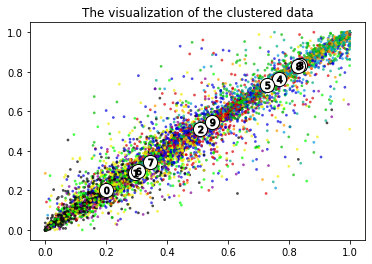

In [106]:
# Plot to show the actual clusters formed
fig, ax = plt.subplots()
colors = cm.nipy_spectral(clusters.astype(float) / 10)
ax.scatter(test_images[:, 0], test_images[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
centers = c_new
# Draw white circles at cluster centers
ax.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax.set_title("The visualization of the clustered data")
plt.show()


In [73]:
#Autoencoder Implementation
input_layer = Input(shape = (32,32,1))
# encoder layers
ec1 = Conv2D(32, 3, activation= 'relu', padding='same')(input_layer)
emp1 = MaxPooling2D(2, padding= 'same')(ec1)
ec2 = Conv2D(64, 3, activation= 'relu', padding='same')(emp1)
emp2 = MaxPooling2D(2, padding= 'same')(ec2)
encoder = Conv2D(128, 3, activation='relu', padding='same')(emp2)
#decoder layers
dc1 = Conv2D(128, 3, activation= 'relu', padding='same')(encoder)
du1 = UpSampling2D(2)(dc1)
dc2 = Conv2D(64, 3, activation= 'relu', padding='same')(du1)
du2 = UpSampling2D(2)(dc2)
decoder = Conv2D(1,3,activation='sigmoid', padding= 'same')(du2) # output layer

encoder_model = Model(input_layer, encoder)
autoencoder = Model(input_layer, decoder)
autoencoder.compile(optimizer= 'adam', loss = 'binary_crossentropy')
autoencoder.summary()



test_images = test_images_base.reshape((len(test_images_base), 32, 32, 1))
autoencoder.fit(train_images, train_images,
                epochs=15,
                batch_size=128,
                validation_data=(test_images, test_images))

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 8, 8, 128)         1475

In [80]:
pred = autoencoder.predict(train_images)

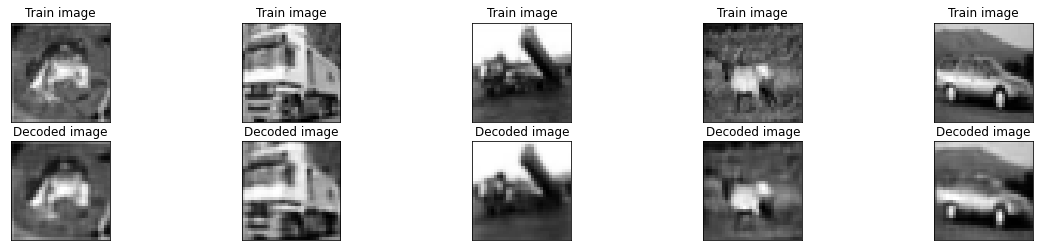

In [81]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Train images
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[i].reshape(32, 32))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
    ax.set_title("Train image")
    # Decoded Images
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(pred[i].reshape(32, 32))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.gray()
    ax.set_title("Decoded image")
plt.show()

In [84]:
encoded_pred = encoder_model.predict(train_images)
print('encoded_pred Images Shape:', encoded_pred.shape)
encoded_pred = encoded_pred.reshape((50000,8192))
random_state = 170
y_pred = KMeans(n_clusters=10, random_state=random_state).fit_predict(encoded_pred)

encoded_pred Images Shape: (50000, 8, 8, 128)


In [85]:
print('y_pred Images Shape:', y_pred.shape)
silhouette_avg = silhouette_score(encoded_pred, y_pred)
print("The average silhouette score is :", silhouette_avg)

y_pred Images Shape: (50000,)
The average silhouette score is : 0.024525054
